In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from neuralop.models import TFNO1d

torch.cuda.empty_cache()

/opt/conda/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
import wandb
import math
import random

wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: siyuanliang97 (siyuanliang97-bupt) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
class Config:
    # DATA_PATH = "Data/satellite_2023_100k.csv"
    DATA_PATH = "Data/residual.csv"
    CHANNELS = ['X', 'Y', 'Z', 'VX', 'VY', 'VZ']
    INPUT_SIZE = 8640
    TARGET_SIZE = 8640
    GAP = 3600
    BATCH_SIZE = 128
    EPOCHS = 30
    LR = 9e-4
    GAMMA = 0.9
    NUM_WORKERS = 10
    POS_VEL_FACTOR = 0
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # CHECKPOINT_DIR = "./checkpoints/EXP_10"
    # WANDB_PROJECT = "orbit_timeseries"
    CHECKPOINT_DIR = "./checkpoints/RES"
    WANDB_PROJECT = "orbit_residual"

In [4]:
# 数据加载函数
def load_data():
    data = pd.read_csv(Config.DATA_PATH)
    data = data[Config.CHANNELS].values.astype(np.float32)
    assert data.shape[0] > Config.INPUT_SIZE + Config.GAP + Config.TARGET_SIZE, "数据长度不足，无法生成样本"
    return data

In [5]:
# class Normalizer:
#     def __init__(self, data):
#         self.mean = np.mean(data, axis=0)
#         self.std = np.std(data, axis=0)
#     def normalize(self, data):
#         return (data - self.mean) / self.std
#     def denormalize(self, data):
#         return data * self.std.reshape(1,-1, 1) + self.mean.reshape(1, -1, 1)

class Normalizer:
    def __init__(self, data):
        # 沿批次和序列长度维度计算均值和标准差
        self.mean = data.mean(dim=(0))
        self.std = data.std(dim=(0))

    def normalize(self, data):
        # 动态调整设备并广播形状
        if data.dim() ==2:
            mean = self.mean.to(data.device) 
            std = self.std.to(data.device)
        elif data.dim() ==3:
            mean = self.mean.to(data.device).unsqueeze(-1)
            std = self.std.to(data.device).unsqueeze(-1)
        return (data - mean) / std

    def denormalize(self, data):
        if data.dim() ==2:
            mean = self.mean.to(data.device) 
            std = self.std.to(data.device)
        elif data.dim() ==3:
            mean = self.mean.to(data.device).unsqueeze(-1)
            std = self.std.to(data.device).unsqueeze(-1)
        return data * std + mean

In [6]:
# # 数据集类定义
# class TimeSeriesPredictionDataset(Dataset):
#     def __init__(self, data, input_size, target_size, gap):
#         self.raw_data = data
#         self.input_size = input_size
#         self.target_size = target_size
#         self.gap = gap

#         self.normalizer = Normalizer(data)
#         self.data = self.normalizer.normalize(self.raw_data)

#     def __len__(self):
#         return len(self.data) - self.input_size - self.gap - self.target_size + 1

#     def __getitem__(self, idx):
#         input_seq = self.data[idx: idx + self.input_size, :]
#         target_seq = self.data[idx + self.gap: idx + self.gap + self.target_size, :]
#         return (torch.tensor(input_seq, dtype=torch.float32),
#                 torch.tensor(target_seq, dtype=torch.float32))

class TimeSeriesPredictionDataset(Dataset):
    def __init__(self, data, input_size, target_size, gap):
        # 确保输入数据为 PyTorch 张量
        self.raw_data = torch.tensor(data, dtype=torch.float32)
        self.input_size = input_size
        self.target_size = target_size
        self.gap = gap

        # 初始化归一化器
        self.normalizer = Normalizer(self.raw_data)
        # 归一化后的数据（张量）
        self.data = self.normalizer.normalize(self.raw_data)

    def __len__(self):
        return len(self.raw_data) - self.input_size - self.gap - self.target_size + 1

    def __getitem__(self, idx):
        # 获取归一化后的张量切片
        input_seq = self.data[idx: idx + self.input_size, :]  # [input_size, channels]
        target_seq = self.data[idx + self.gap: idx + self.gap + self.target_size, :]  # [target_size, channels]

        # # 调整形状为 [channels, seq_len]（适配模型输入）
        # input_seq = input_seq.permute(1, 0)  # [channels, input_size]
        # target_seq = target_seq.permute(1, 0)  # [channels, target_size]
        return input_seq, target_seq


In [7]:
# 构造 DataLoader
def get_dataloaders(data):
    dataset = TimeSeriesPredictionDataset(data, Config.INPUT_SIZE, Config.TARGET_SIZE, Config.GAP)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, test_size], generator=torch.Generator().manual_seed(42))
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=Config.NUM_WORKERS)
    return train_loader, test_loader, dataset

In [8]:
def build_model():
    in_channels = len(Config.CHANNELS)
    model = TFNO1d(
        n_modes_height=8,
        in_channels=in_channels,
        out_channels=in_channels,
        hidden_channels=256
    ).to(Config.DEVICE)
    return model

In [9]:
def plot_results(input_data, output_data, target_data, normalizer, channel_names, original_position, num_points=8640):

    # input_data, output_data, target_data 的 shape 为 [batch, channels, seq_len]
    input_denorm = normalizer.denormalize(input_data).cpu()
    output_denorm = normalizer.denormalize(output_data).cpu()
    target_denorm = normalizer.denormalize(target_data).cpu()
    out_channels = len(channel_names)

    plt.figure(figsize=(12, out_channels * 3))
    for channel in range(out_channels):
        plt.subplot(out_channels, 2, 2 * channel + 1)
        plt.plot(input_denorm[0, channel, -num_points:], label="Input")
        plt.plot(output_denorm[0, channel, -num_points:], label="Predicted")
        plt.plot(target_denorm[0, channel, -num_points:], label="Target")
        plt.title(f"{channel_names[channel]} - Start from: {original_position}")
        plt.legend(loc='upper right')

        plt.subplot(out_channels, 2, 2 * channel + 2)
        error = output_denorm[0, channel, -num_points:] - target_denorm[0, channel, -num_points:]
        plt.plot(error, color="red", label="Error")
        plt.title(f"{channel_names[channel]} Error")
        plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

In [10]:
def vel2position(output, factor, dataset):    
    output = dataset.normalizer.normalize(output)
    delta_t = 10
        
    pos_output = output[:, :3, :]  # 位置通道 [x, y, z]
    vel_output = output[:, 3:, :]  # 速度通道 [vx, vy, vz]
        
    if pos_output.size(2) >= 3:
        # 中心导数计算 (x_{i+1} - x_{i-1}) / (2*delta_t)
        pos_deriv = (pos_output[:, :, 2:] - pos_output[:, :, :-2]) / (2 * delta_t)
        # 速度的中间部分（去掉首尾时间步）
        vel_mid = vel_output[:, :, 1:-1]
        # 物理损失：导数与速度的MSE
        physics_loss = torch.mean((pos_deriv - vel_mid)**2)
    else:
        physics_loss = torch.tensor(0.0, device=output.device)
    return factor*physics_loss

In [11]:
class Trainer:
    def __init__(self, model, train_loader, test_loader, loss_fn, optimizer, scheduler, dataset):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.dataset = dataset
        self.device = Config.DEVICE
        self.best_loss = float('inf')
        os.makedirs(Config.CHECKPOINT_DIR, exist_ok=True)
        # 初始化 wandb
        wandb.init(project=Config.WANDB_PROJECT, config={
            "batch_size": Config.BATCH_SIZE,
            "epochs": Config.EPOCHS,
            "lr": Config.LR,
            "pos_vel": Config.POS_VEL_FACTOR
        })
        self.global_step = 0

    def train(self, epochs):
        loss_log = []
        for epoch in range(epochs):
            self.model.train()
            epoch_loss = 0.0
            for batch_idx, (input_data, target_data) in enumerate(self.train_loader):
                input_data = input_data.to(self.device).permute(0, 2, 1)
                target_data = target_data.to(self.device).permute(0, 2, 1)
                self.optimizer.zero_grad()
                output = self.model(input_data)
                out_channels = output.shape[1]
                channel_losses = []

                
                for ch in range(out_channels):
                    ch_loss = self.loss_fn(output[:, ch, :], target_data[:, ch, :])
                    channel_losses.append(ch_loss)

                loss = sum(channel_losses) / out_channels  + vel2position(output, Config.POS_VEL_FACTOR ,self.dataset)
                loss.backward()
                self.optimizer.step()
                epoch_loss += loss.item()
                self.global_step += 1
                # 记录每个 batch 的损失到 wandb
                wandb.log({"Train/BatchLoss": loss.item()}, step=self.global_step)
            epoch_loss /= len(self.train_loader)
            loss_log.append(epoch_loss)
            self.scheduler.step()
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.8f}")
            wandb.log({"Train/EpochLoss": epoch_loss}, step=self.global_step)
            if epoch_loss < self.best_loss:
                self.best_loss = epoch_loss
                self.save_checkpoint(epoch)
            # 每个 epoch 结束后进行验证，并记录验证指标
            val_loss = self.evaluate(epoch)
            wandb.log({"Validation/Loss": val_loss}, step=self.global_step)
        return loss_log

    def evaluate(self, epoch=None):
        self.model.eval()
        total_loss = 0.0
        out_channels = len(Config.CHANNELS)
        with torch.no_grad():
            for input_data, target_data in self.test_loader:
                input_data = input_data.to(self.device).permute(0, 2, 1)
                target_data = target_data.to(self.device).permute(0, 2, 1)
                output = self.model(input_data)
                batch_loss = 0.0
                for ch in range(out_channels):
                    ch_loss = self.loss_fn(output[:, ch, :], target_data[:, ch, :])
                    batch_loss += ch_loss.item()
                total_loss += batch_loss / out_channels
        total_loss /= len(self.test_loader)
        if epoch is not None:
            print(f"Epoch {epoch+1} Evaluation Loss: {total_loss:.8f}")
        return total_loss

    def save_checkpoint(self, epoch):
        checkpoint_path = os.path.join(Config.CHECKPOINT_DIR, f"model_epoch_{epoch+1}_loss_{self.best_loss:.8f}.pt")
        torch.save(self.model.state_dict(), checkpoint_path)
        print(f"Saved checkpoint: {checkpoint_path}")
        # 记录 checkpoint 文件路径到 wandb
        wandb.save(checkpoint_path)


In [ ]:
if __name__ == "__main__":
    data = load_data()
    train_loader, test_loader, dataset = get_dataloaders(data)
    model = build_model()
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=Config.LR)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=Config.GAMMA)
    trainer = Trainer(model, train_loader, test_loader, loss_fn, optimizer, scheduler, dataset)
    loss_log = trainer.train(Config.EPOCHS)
    eval_loss = trainer.evaluate()

    # 可视化测试结果
    model.eval()
    with torch.no_grad():
        input_data, target_data = next(iter(test_loader))
        input_data = input_data.to(Config.DEVICE).permute(0, 2, 1)
        output_data = model(input_data)
        input_np = input_data
        output_np = output_data
        target_np = target_data.to(Config.DEVICE).permute(0, 2, 1)
        plot_results(input_np, output_np, target_np, dataset.normalizer, Config.CHANNELS, original_position=0)
    wandb.finish()

Epoch 1/30, Loss: 0.03049943
Saved checkpoint: ./checkpoints/RES/model_epoch_1_loss_0.03049943.pt
Epoch 1 Evaluation Loss: 0.00119730
Epoch 2/30, Loss: 0.00077009
Saved checkpoint: ./checkpoints/RES/model_epoch_2_loss_0.00077009.pt
Epoch 2 Evaluation Loss: 0.00054882
Epoch 3/30, Loss: 0.00048916
Saved checkpoint: ./checkpoints/RES/model_epoch_3_loss_0.00048916.pt
Epoch 3 Evaluation Loss: 0.00037374
Epoch 4/30, Loss: 0.00037807
Saved checkpoint: ./checkpoints/RES/model_epoch_4_loss_0.00037807.pt
Epoch 4 Evaluation Loss: 0.00027725
Epoch 5/30, Loss: 0.00026382
Saved checkpoint: ./checkpoints/RES/model_epoch_5_loss_0.00026382.pt
Epoch 5 Evaluation Loss: 0.00020000
Epoch 6/30, Loss: 0.00017173
Saved checkpoint: ./checkpoints/RES/model_epoch_6_loss_0.00017173.pt
Epoch 6 Evaluation Loss: 0.00011223
Epoch 7/30, Loss: 0.00013431
Saved checkpoint: ./checkpoints/RES/model_epoch_7_loss_0.00013431.pt
Epoch 7 Evaluation Loss: 0.00009109
Epoch 8/30, Loss: 0.00008823
Saved checkpoint: ./checkpoints/R

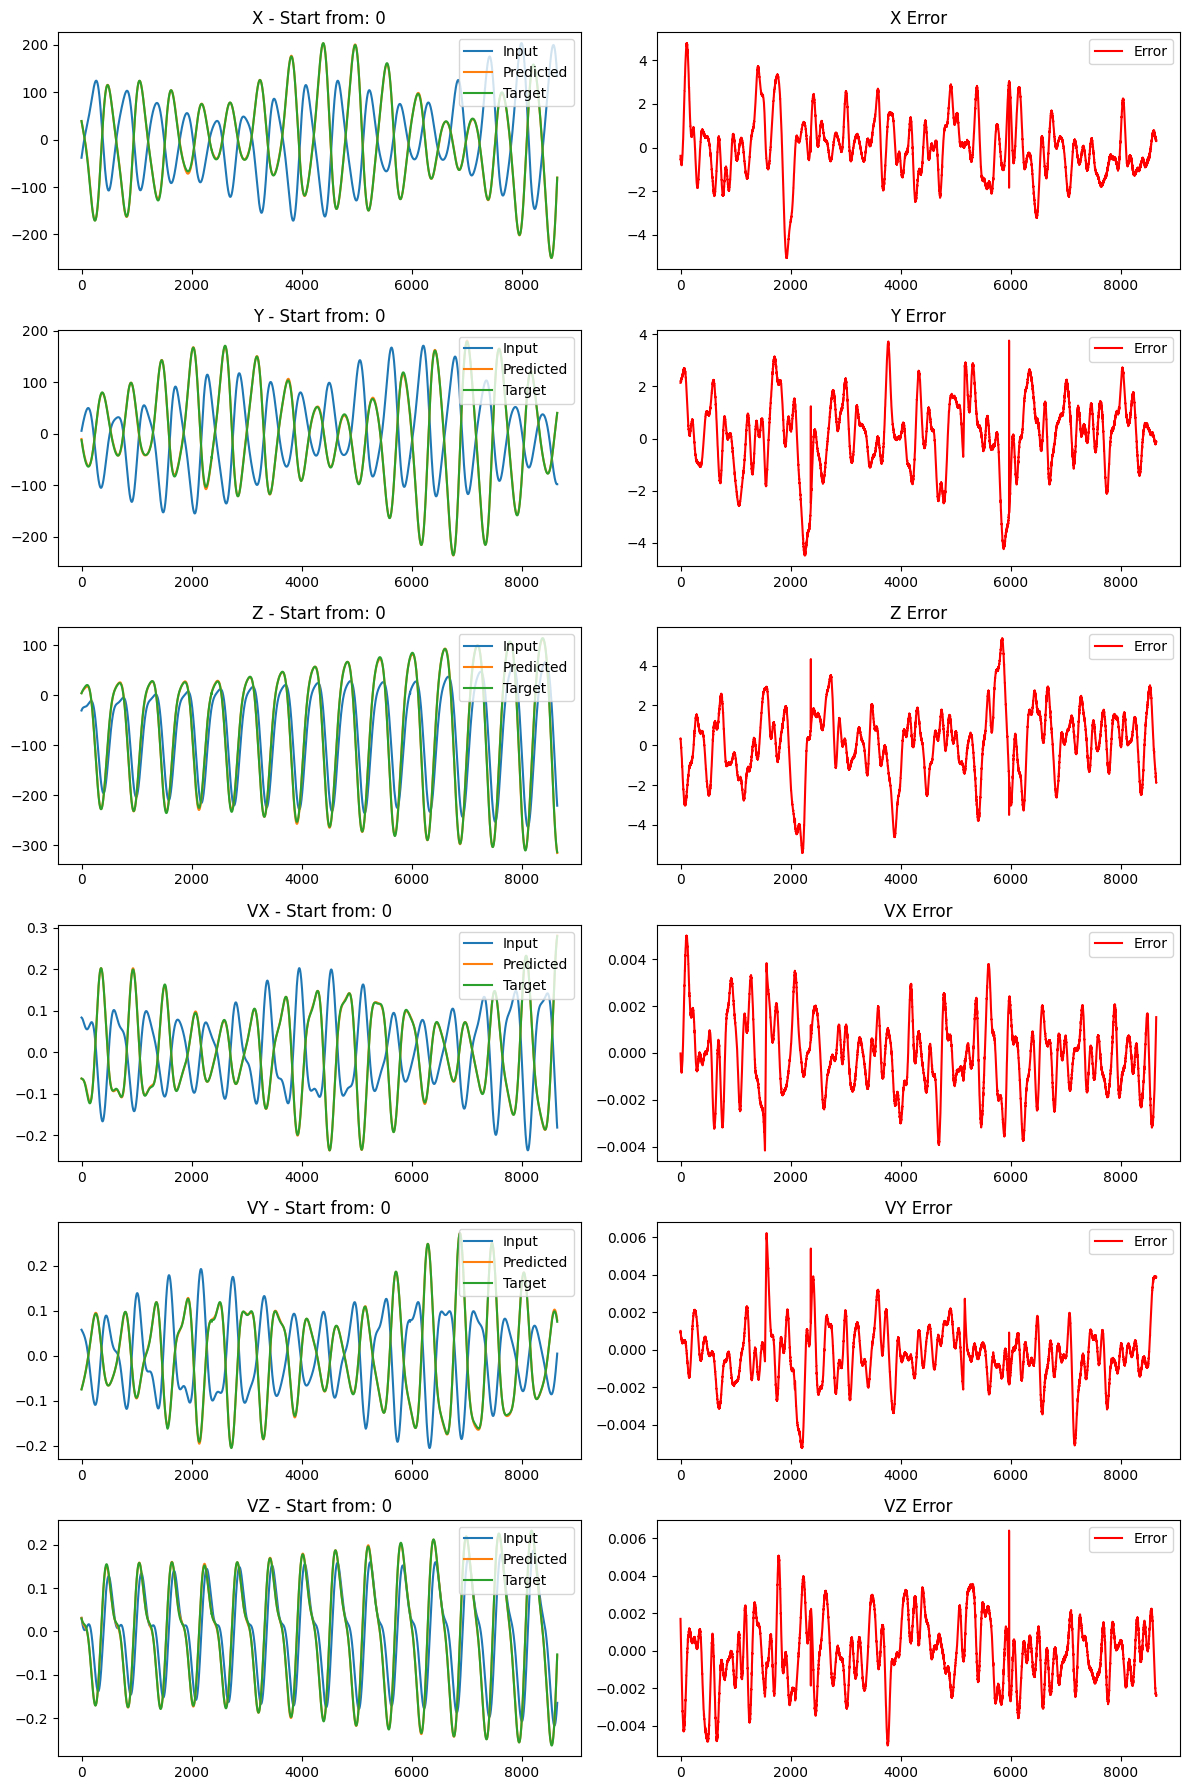

In [13]:
model = build_model()
state_dict = torch.load('./checkpoints/RES/model_epoch_30_loss_0.00000755.pt', weights_only = False)
model.load_state_dict(state_dict)

data = load_data()
train_loader, test_loader, dataset = get_dataloaders(data)

# 可视化测试结果
model.eval()
with torch.no_grad():
    input_data, target_data = next(iter(test_loader))
    input_data = input_data.to(Config.DEVICE).permute(0, 2, 1)
    output_data = model(input_data)
    input_np = input_data
    output_np = output_data
    target_np = target_data.to(Config.DEVICE).permute(0, 2, 1)
    plot_results(input_np, output_np, target_np, dataset.normalizer, Config.CHANNELS, original_position=0)

RuntimeError: operator torchvision::nms does not exist